# Solar Calculations
In shadow flickering calculations, determining the sun's path for a specified longitude and latitude is important for precise simulation of the shadow dynamics induced by wind turbines.

The altitude and azimuth positions of the sun fluctuate throughout the day and across seasons. Computing the sun's path for a particular longitude and latitude allows us to model the dynamic sun positions over time, thereby capturing the temporal variations in shadow patterns.

The calculations presented in this chapter are based on the principles outlined in {cite:t}`sun_calc`.

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import print_code, solar_angles_to_vector, solar_position, add_solar_axis
import numpy as np
from IPython.core.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from datetime import datetime
import matplotlib.dates as mdates

## Calculate Azimuth and Altitude of Sun
The key objective of solar calculations is to estimate the azimuth and altitude of the sun at a specified longitude, latitude, date, and time. The following code snippet achieves excactly this:

In [2]:
HTML(print_code(solar_position))

### Test of Script
Here is a brief test of the script, where the azimuth and altitude of the sun are determined in Copenhagen on the 6th of June at 12 o'clock.

In [3]:
date = datetime(2023, 6, 15, 12, 0, 0)
lat = 55.692858003050134 # Copenhagen
lng = 12.599278148554639

az, alt = solar_position(date, lat, lng)

print(f"Azimuth: {np.degrees(az):.2f} degrees")
print(f"Altitude: {np.degrees(alt):.2f} degrees")

Azimuth: 200.86 degrees
Altitude: 56.33 degrees


## Convertion to Unit Vector
Thereafter, the altitude and azimuth position of the sun is converted into a unit vector, such that it can be used by the ray tracing algorithm.

In [4]:
HTML(print_code(solar_angles_to_vector))

### Test of Script
Below a small test of the script can be found. Note that the vector defines the direction vector from the ground towards the sun.

In [5]:
vec = solar_angles_to_vector(135, 179)
print(f"Components of unit vector:\nX: {vec[0]:.2f}\nY: {vec[1]:.2f}\nZ: {vec[2]:.2f}\n")

Components of unit vector:
X: -0.09
Y: 0.99
Z: 0.07



## Solar Analemma
An analemma is a figure-eight curve that illustrates the Sun's changing position at the same time each day throughout the year. This curve can be generated by plotting the Sun's location from a fixed spot on Earth daily or by graphing its declination against time. The size and shape of the analemma are influenced by the observer's position, providing a visual representation of the Sun's varying position throughout the year.

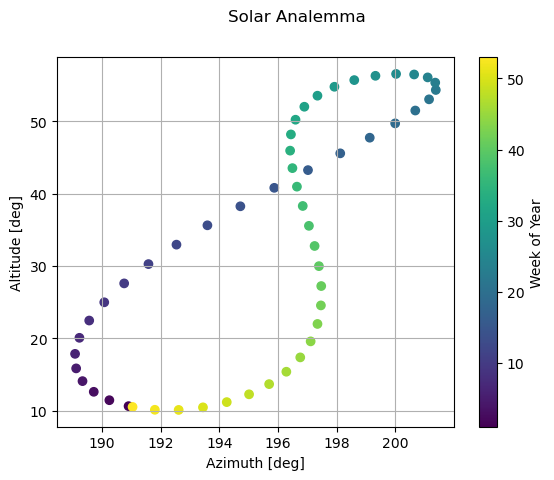

In [6]:
start_date = '2023-01-01 12:00:00'
end_date = '2023-12-31 12:00:00'
date_range = pd.date_range(start=start_date, end=end_date, freq="W")
sun_pos = np.empty([len(date_range), 2])
fig, ax = plt.subplots()
fig.suptitle("Solar Analemma")
for i, date in enumerate(date_range):
    az, alt = solar_position(date, lat, lng)
    sun_pos[i,:] = az, alt

scat = ax.scatter(*np.rad2deg(sun_pos).T, marker="o", c=date_range.strftime('%U').astype(int).tolist(), cmap='viridis')
cbar = plt.colorbar(scat, ax = ax)
cbar.set_label('Week of Year')
ax.set(xlabel = "Azimuth [deg]",
       ylabel = "Altitude [deg]",
       aspect = "auto")
ax.grid()
plt.show()

## Position of the sun throughout the day
Using the previously displayed functions, the path of the sun throughout the day can be mapped you as below:

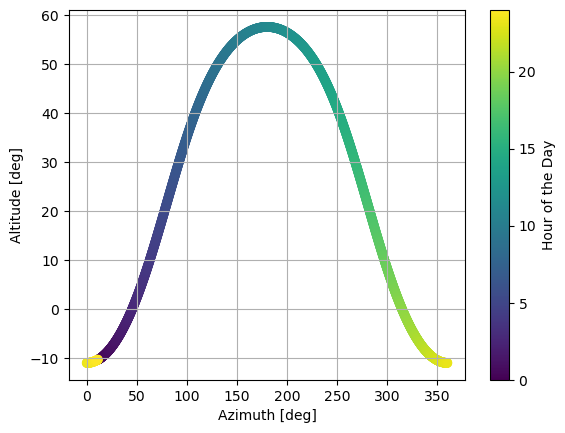

In [7]:
start_date = '2023-06-15 00:00:00'
end_date = '2023-06-15 23:59:59'
date_range = pd.date_range(start=start_date, end=end_date, freq="min")
sun_pos = np.zeros([len(date_range), 2])
sun_vec = np.zeros([len(date_range), 3])
fig, ax = plt.subplots()
for i, date in enumerate(date_range):
    az, alt = solar_position(date, lat, lng)
    sun_pos[i,:] = az, alt
    sun_vec[i,:] = solar_angles_to_vector((az), (alt))

hours_of_day = date_range.hour + date_range.minute / 60
scat = ax.scatter(*np.rad2deg(sun_pos).T, c = hours_of_day)
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label("Hour of the Day")
ax.set(xlabel = "Azimuth [deg]",
       ylabel = "Altitude [deg]",
       aspect = "auto")
ax.grid()
plt.show()

Alternatively, the information can also be displayed using two plots as seen below:

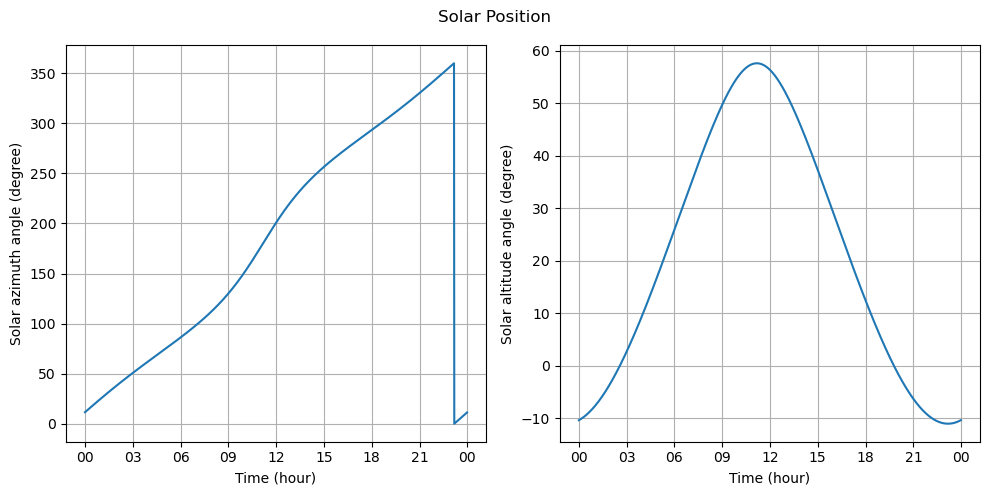

In [8]:
# Plots for solar zenith and solar azimuth angles
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Solar Position')

# plot for solar zenith angle
axs[0].plot(date_range, np.rad2deg(sun_pos[:,0]))
axs[0].set_ylabel('Solar azimuth angle (degree)')
axs[0].set_xlabel('Time (hour)')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth angle
axs[1].plot(date_range,  np.rad2deg(sun_pos[:,1]))
axs[1].set_ylabel('Solar altitude angle (degree)')
axs[1].set_xlabel('Time (hour)')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

[ax.grid(True) for ax in axs.flatten()]
plt.tight_layout()

## Sun path on a polar graph
Finally, utilizing the functions to showcase the sun path on a polar graph provides a clear visualization of the solar trajectory throughout the day and across seasons. This proves to be an effective tool for comprehending solar dynamics in various geographic locations.

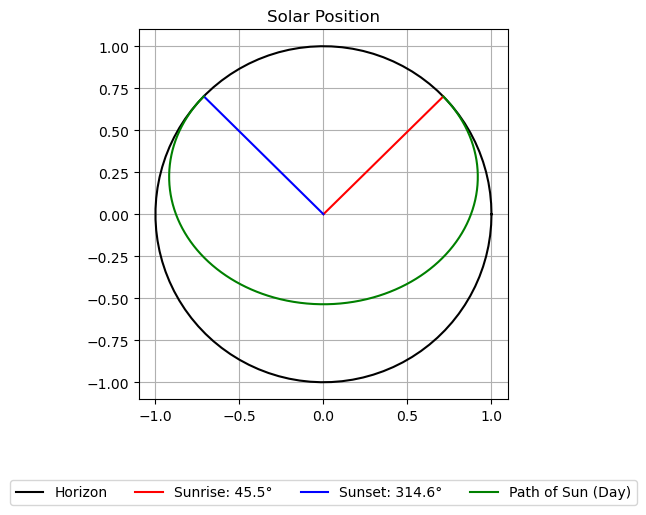

In [9]:
positive_indices = np.where(sun_pos[:,1] > 0)[0]

if positive_indices.size > 0:
    first_azimuth, last_azimuth = sun_pos[positive_indices[[0, -1]], 0]

# Create a unit circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_coords = np.array([np.cos(theta), np.sin(theta)])
sunrise_vec = np.array([[0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)]])

fig, ax = plt.subplots()
ax.plot(*circle_coords, 'k', label = "Horizon") # circle
ax.plot([0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)], 'r', label=f'Sunrise: {np.rad2deg(first_azimuth):.1f}°')
ax.plot([0, np.sin(last_azimuth)], [0, np.cos(last_azimuth)], 'b', label=f'Sunset: {np.rad2deg(last_azimuth):.1f}°')
ax.plot(sun_vec[:,0][sun_vec[:,2] > 0], sun_vec[:,1][sun_vec[:,2] > 0], "g-", label = "Path of Sun (Day)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

ax.set_aspect('equal', adjustable='box')
plt.title('Solar Position')
plt.grid()
plt.show()

Furthermore, this solar position can when be plotted on a map.

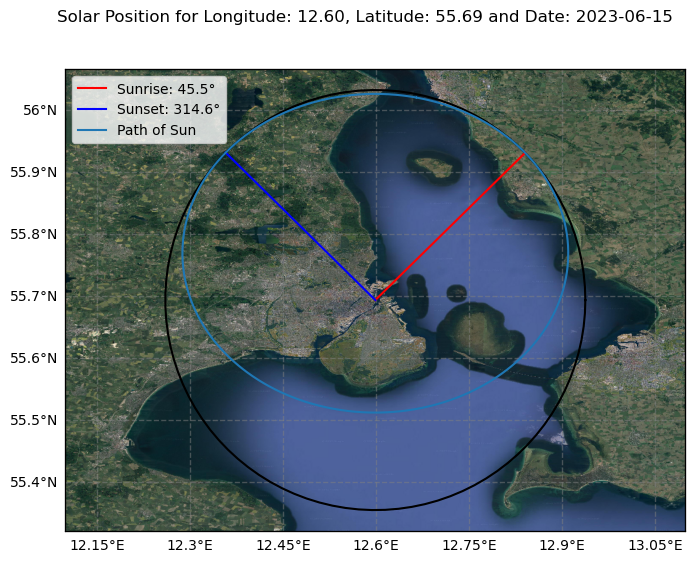

In [10]:
proj = ccrs.PlateCarree()
size = 0.5 # size of map radius
extent = [lng - size, lng + size, lat - size, lat + size]# Specify the map extent (latitude and longitude bounds)

fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(8, 6))
ax.set_extent(extent, crs=proj)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 12) # 16
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle(f"Solar Position for Longitude: {lng:.2f}, Latitude: {lat:.2f} and Date: " + start_date[:10])
ax2 = add_solar_axis(fig, ax)

ax2.plot(*circle_coords, 'k') # circle
ax2.plot([0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)], 'r', label=f'Sunrise: {np.rad2deg(first_azimuth):.1f}°')
ax2.plot([0, np.sin(last_azimuth)], [0, np.cos(last_azimuth)], 'b', label=f'Sunset: {np.rad2deg(last_azimuth):.1f}°')
ax2.plot(sun_vec[:,0], sun_vec[:,1], label = "Path of Sun")
ax2.legend(loc = "upper left")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()